In [124]:
import sys
sys.path.insert(0, '..')
import utils.game_utils as gu

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def get_previous_record(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records[-1:]


def get_all_previous_records(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records

def trim_df(df, fields=None):
    if fields is None:
        fields = [
            'team_wins_before',
            'team_losses_before', 'team_ties_before', 'team_wins_after',
            'team_losses_after', 'team_ties_after', 'team_record_total_before',
            'team_record_total_after', 'team_record_normal_before',
            'team_record_normal_after', 'team_opprec_normal_before',
            'team_opprec_normal_after'
        ]
    out_fields = ['year', 'week', 'team_win', 'team']
    out_fields.extend(fields)
    return df[out_fields]


all_games_df = pd.read_csv('../../data/games/all_games_with_data.csv')


In [140]:
def get_df_with_aggregates(index, all_games_df, side='team'):
    SIDE = side # can be opponent
    OTHER_SIDE = 'opponent' if SIDE == 'team' else 'team'
    game_df = all_games_df.iloc[index]
    year = game_df['year']
    week = game_df['week']
    team = game_df[SIDE]
    opp_team = game_df[OTHER_SIDE]

    previous_df = get_previous_record(year, week, team, all_games_df)
    opp_previous_df = get_previous_record(year, week, opp_team, all_games_df)

    wins_before = 0
    losses_before = 0
    ties_before = 0

    wins_after = 0
    losses_after = 0
    ties_after = 0

    # todo: still need to handle these (before and after?)
    record_total_before = 0
    record_total_after = 0
    record_normal_before = 0
    record_normal_after = 0
    opp_strength_before = 0
    opp_strength_after = 0
    # accumulated normalized records of all opponents
    opprec_normal_before = 0
    opprec_normal_after = 1.0



    ## INFO FROM THIS GAME
    win = bool(game_df[f'{SIDE}_win'])
    tie = game_df['team_score'] == game_df['opponent_score'] # no need for SIDE, just see if both scores are the same
    loss = win == False and tie == False

    def get_val_or(df, field):
        val = df.iloc[0][field]
        if np.isnan(val):
            return 0
        return val
    def get_normalized(x, min, max):
        return (x-min) / (max-min)

    def get_opprec_normal_after(opp_previous_df, record_normal_after):
        if opp_previous_df is None:
            return 1.0

        pre_week = get_val_or(opp_previous_df, 'week')
        pre_opprec_after = get_val_or(opp_previous_df,
                                      f'{SIDE}_opprec_normal_after')
        pre_trn_after = get_val_or(opp_previous_df,
                                   f'{SIDE}_record_normal_after')

        new_opprec = (pre_opprec_after + pre_trn_after) / 2
        final_new_opprec = (new_opprec + record_normal_after) / 2

        return final_new_opprec

    def get_opp_strength_after(opp_previous_df, opp_strength_before):
        '''
        Opponent Strength is essentially the TRN value
        (record_normal) or the wins/losses of a team.
        We want to accumulate the opp_strength from week to
        week to see how strong all opponents have been.
        '''
        if week == 1:
            return 1.0
        if opp_previous_df is None:
            return 1.0

        opp_prev_trn = get_val_or(opp_previous_df, f'{SIDE}_record_normal_after')
        # normalized (/2)
        return (opp_strength_before + opp_prev_trn) / 2


    ## DATA FROM PREVIOUS GAME
    if previous_df is not None:
        try:
            wins_before = get_val_or(previous_df, f'{SIDE}_wins_after')
            losses_before = get_val_or(previous_df, f'{SIDE}_losses_after')
            ties_before = get_val_or(previous_df, f'{SIDE}_ties_after')
            record_total_before = get_val_or(previous_df,
                                              f'{SIDE}_record_total_after')
            record_normal_before = get_val_or(previous_df,
                                              f'{SIDE}_record_normal_after')
            opprec_normal_before = get_val_or(previous_df,
                                              f'{SIDE}_opprec_normal_after')
            opp_strength_before = get_val_or(previous_df,
                                              f'{SIDE}_opp_strength_after')

            wins_after = wins_before
            losses_after = losses_before
            ties_after = ties_before
            record_total_after = record_total_before
            record_normal_after = record_normal_before
            opprec_normal_after = get_opprec_normal_after(
                opp_previous_df, record_normal_after)

            opp_strength_after = get_opp_strength_after(
                opp_previous_df, opp_strength_before)

        except Exception as e:
            print(e)

    ## CALCULATE NEW DATA (after)
    if win:
        wins_after += 1
    if tie:
        ties_after += 1
    if loss:
        losses_after += 1

    ## CALCULATE RECORD NORMAL
    record_total_after = wins_after - losses_after # eg: +2 or -7 etc.
    record_normal_after = get_normalized(record_total_after, week * -1, week)


    # todo: maybe we should be authoring is_tie as well?

    all_games_df.at[index, [
        f'{SIDE}_wins_before',
        f'{SIDE}_wins_after',
        f'{SIDE}_losses_before',
        f'{SIDE}_losses_after',
        f'{SIDE}_ties_before',
        f'{SIDE}_ties_after',
        f'{SIDE}_record_total_before',
        f'{SIDE}_record_total_after',
        f'{SIDE}_record_normal_before',
        f'{SIDE}_record_normal_after',
        f'{SIDE}_opp_strength_before',
        f'{SIDE}_opp_strength_after',
        f'{SIDE}_opprec_normal_before',
        f'{SIDE}_opprec_normal_after',
    ]] = [
        wins_before, wins_after, losses_before, losses_after, ties_before,
        ties_after, record_total_before, record_total_after,
        record_normal_before, record_normal_after, opp_strength_before,
        opp_strength_after, opprec_normal_before,
        opprec_normal_after
    ]

    return all_games_df.iloc[index]




def get_team_df(team, year, all_df):
    return all_df[(all_df['team'] == team) & (all_df['year'] == year)]

def get_year_df(year, all_df):
    return all_df[all_df['year'] == year]

def get_year_up_to_week_df(year, week, all_df):
    return all_df[(all_df['year'] == year) & (all_df['week'] <= week)]


## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
## C O N F I G
## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
YEAR = 2018
UP_TO_WEEK = 16
## ADD NEW COLUMNS TO ALL GAMES AND CREATE NEW ALL_GAMES_PLUS_DF (agp_df)
new_col_df = pd.DataFrame(columns=[
    'team_wins_before', 'team_losses_before', 'team_ties_before',
    'team_record_total_before', 'team_record_normal_before', 'team_wins_after',
    'team_losses_after', 'team_ties_after', 'team_record_total_after',
    'team_record_normal_after', 'team_opp_strength_before',
    'team_opp_strength_after', 'team_opprec_normal_before',
    'team_opprec_normal_after'
])
agp_df = all_games_df.join(new_col_df, how="outer")
year_df = get_year_df(YEAR, agp_df)
# year_df = get_year_up_to_week_df(YEAR, UP_TO_WEEK, agp_df)

for index in year_df.index:
    get_df_with_aggregates(index, agp_df)

show_fields = [
    'opponent', 'team_wins_after', 'team_losses_after', 'team_ties_after',
    'team_record_total_after', 'team_record_normal_after',
    'team_opp_strength_before', 'team_opp_strength_after',
    'team_opprec_normal_before', 'team_opprec_normal_after'
]

year_df = get_year_df(YEAR, agp_df)
# year_df = get_year_up_to_week_df(YEAR, UP_TO_WEEK, agp_df)
# trim_df(year_df, show_fields)

team_df = year_df[year_df['team'] == gu.TEAM_NAME['Saints']]
trim_df(team_df, show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_total_after,team_record_normal_after,team_opp_strength_before,team_opp_strength_after,team_opprec_normal_before,team_opprec_normal_after
4106,2018,1,0,New Orleans Saints,Tampa Bay Buccaneers,0,1,0,-1,0.0,0,0,0,1.0
4144,2018,2,1,New Orleans Saints,Cleveland Browns,1,1,0,0,0.5,0,0.25,1.0,0.375
4165,2018,3,1,New Orleans Saints,Atlanta Falcons,2,1,0,1,0.666667,0.25,0.375,0.375,0.5
4217,2018,4,1,New Orleans Saints,New York Giants,3,1,0,2,0.75,0.375,0.354167,0.5,0.432292
4250,2018,5,1,New Orleans Saints,Washington Redskins,4,1,0,3,0.8,0.354167,0.510417,0.432292,0.713542
4301,2018,7,1,New Orleans Saints,Baltimore Ravens,5,1,0,4,0.785714,0.510417,0.588542,0.713542,0.713753
4335,2018,8,1,New Orleans Saints,Minnesota Vikings,6,1,0,5,0.8125,0.588542,0.651414,0.713753,0.707781
4358,2018,9,1,New Orleans Saints,Los Angeles Rams,7,1,0,6,0.833333,0.651414,0.825707,0.707781,0.83892
4367,2018,10,1,New Orleans Saints,Cincinnati Bengals,8,1,0,7,0.85,0.825707,0.725353,0.83892,0.702841
4412,2018,11,1,New Orleans Saints,Philadelphia Eagles,9,1,0,8,0.863636,0.725353,0.587677,0.702841,0.653099


In [119]:
team_df = year_df[year_df['team'] == gu.TEAM_NAME['Falcons']]
trim_df(team_df, show_fields)

,year,week,team_win,team,opponent,team_wins_after,team_losses_after,team_ties_after,team_record_total_after,team_record_normal_after,team_opprec_normal_before,team_opprec_normal_after
4097,2018,1,0,Atlanta Falcons,Philadelphia Eagles,0,1,0,-1,0.0,0,1.0
4132,2018,2,1,Atlanta Falcons,Carolina Panthers,1,1,0,0,0.5,1.0,0.5
4164,2018,3,0,Atlanta Falcons,New Orleans Saints,1,2,0,-1,0.333333,0.5,0.46875
4196,2018,4,0,Atlanta Falcons,Cincinnati Bengals,1,3,0,-2,0.25,0.46875,0.536458
4229,2018,5,0,Atlanta Falcons,Pittsburgh Steelers,1,4,0,-3,0.2,0.536458,0.417969
4256,2018,6,1,Atlanta Falcons,Tampa Bay Buccaneers,2,4,0,-2,0.333333,0.417969,0.373437
4308,2018,7,1,Atlanta Falcons,New York Giants,3,4,0,-1,0.428571,0.373437,0.293571
4345,2018,9,1,Atlanta Falcons,Washington Redskins,4,4,0,0,0.5,0.293571,0.491698
4381,2018,10,0,Atlanta Falcons,Cleveland Browns,4,5,0,-1,0.45,0.491698,0.451442
4394,2018,11,0,Atlanta Falcons,Dallas Cowboys,4,6,0,-2,0.409091,0.451442,0.444939


<AxesSubplot:xlabel='week', ylabel='team_opprec_normal_after'>

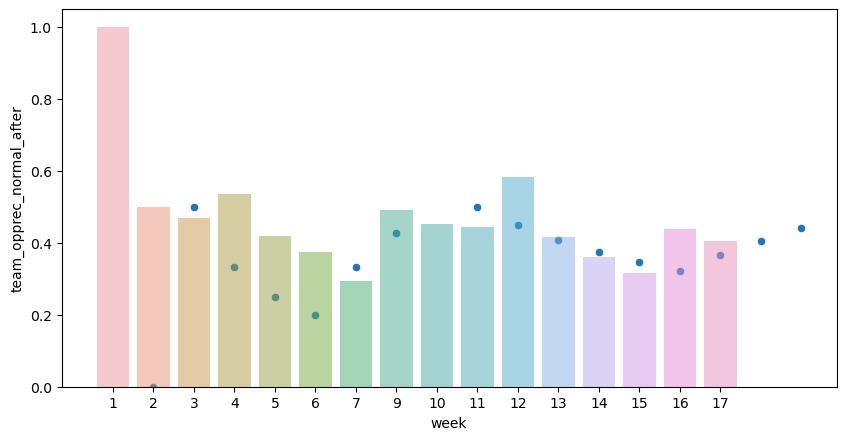

In [87]:
plt.figure(figsize=(10, 5), dpi=100)
sns.barplot(data=team_df, x='week', y='team_opprec_normal_after', alpha=0.5)
sns.scatterplot(data=team_df, x='week', y='team_record_normal_after')


,week,team_record_normal_after,team_wins_after,team_losses_after
4097,1,0.0,0,1
4132,2,0.5,1,1
4164,3,0.333333,1,2
4196,4,0.25,1,3
4229,5,0.2,1,4
4256,6,0.333333,2,4
4308,7,0.428571,3,4
4345,9,0.5,4,4
4381,10,0.45,4,5
4394,11,0.409091,4,6


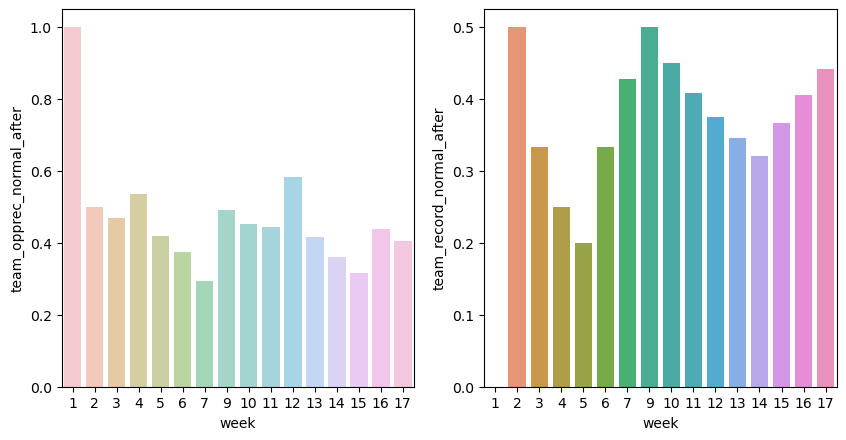

In [97]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
# plt.figure(figsize=(10, 5), dpi=100)
sns.barplot(data=team_df,
            x='week',
            y='team_opprec_normal_after',
            alpha=0.5,
            ax=axs[0])
sns.barplot(data=team_df, x='week', y='team_record_normal_after', ax=axs[1])
team_df[['week','team_record_normal_after','team_wins_after', 'team_losses_after']]

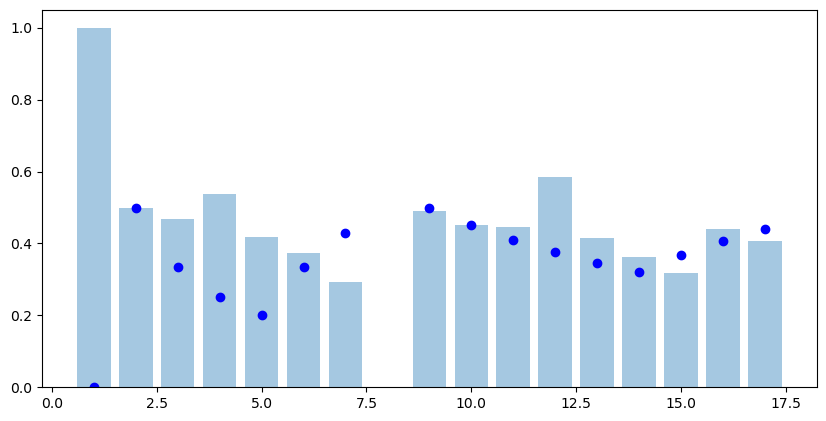

In [112]:
plt.figure(figsize=(10, 5), dpi=100)
weeks = team_df['week']
trn = team_df['team_record_normal_after']
opprec = team_df['team_opprec_normal_after']

plt.bar(weeks, opprec, alpha=0.4)
plt.plot(weeks, trn, 'bo')


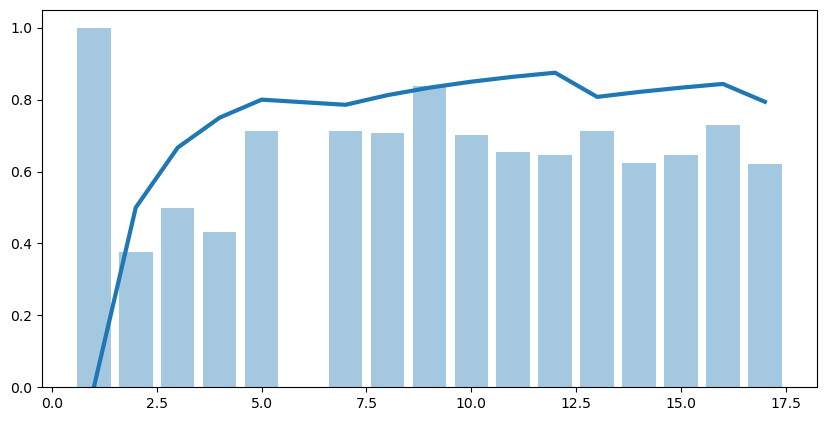

In [126]:
team_df = year_df[year_df['team'] == gu.TEAM_NAME['Saints']]
plt.figure(figsize=(10, 5), dpi=100)
weeks = team_df['week']
trn = team_df['team_record_normal_after']
opprec = team_df['team_opprec_normal_after']

plt.bar(weeks, opprec, alpha=0.4)
plt.plot(weeks, trn, lw=3)

In [142]:
show_fields = [
    'opponent',
    # 'team_wins_after', 'team_losses_after', 'team_ties_after',
    # 'team_record_total_after',
    # 'team_record_normal_before',
    'team_record_normal_after',
    'team_opp_strength_before',
    'team_opp_strength_after',
    # 'team_opprec_normal_before',
    # 'team_opprec_normal_after'
]

In [143]:
trim_df(year_df[year_df['team'] == gu.TEAM_NAME['Saints']], show_fields)

,year,week,team_win,team,opponent,team_record_normal_after,team_opp_strength_before,team_opp_strength_after
4106,2018,1,0,New Orleans Saints,Tampa Bay Buccaneers,0.0,0,0
4144,2018,2,1,New Orleans Saints,Cleveland Browns,0.5,0,0.25
4165,2018,3,1,New Orleans Saints,Atlanta Falcons,0.666667,0.25,0.375
4217,2018,4,1,New Orleans Saints,New York Giants,0.75,0.375,0.354167
4250,2018,5,1,New Orleans Saints,Washington Redskins,0.8,0.354167,0.510417
4301,2018,7,1,New Orleans Saints,Baltimore Ravens,0.785714,0.510417,0.588542
4335,2018,8,1,New Orleans Saints,Minnesota Vikings,0.8125,0.588542,0.651414
4358,2018,9,1,New Orleans Saints,Los Angeles Rams,0.833333,0.651414,0.825707
4367,2018,10,1,New Orleans Saints,Cincinnati Bengals,0.85,0.825707,0.725353
4412,2018,11,1,New Orleans Saints,Philadelphia Eagles,0.863636,0.725353,0.587677


In [133]:
trim_df(year_df[year_df['team'] == gu.TEAM_NAME['Redskins']], show_fields)

,year,week,team_win,team,opponent,team_record_normal_before,team_record_normal_after,team_opprec_normal_before,team_opprec_normal_after
4121,2018,1,1,Washington Redskins,Arizona Cardinals,0,1.0,0,1.0
4134,2018,2,0,Washington Redskins,Indianapolis Colts,1.0,0.5,1.0,0.75
4166,2018,3,1,Washington Redskins,Green Bay Packers,0.5,0.666667,0.75,0.6875
4251,2018,5,0,Washington Redskins,New Orleans Saints,0.666667,0.5,0.6875,0.628906
4258,2018,6,1,Washington Redskins,Carolina Panthers,0.5,0.583333,0.628906,0.552604
4302,2018,7,1,Washington Redskins,Dallas Cowboys,0.583333,0.642857,0.552604,0.557064
4321,2018,8,1,Washington Redskins,New York Giants,0.642857,0.6875,0.557064,0.422149
4344,2018,9,0,Washington Redskins,Atlanta Falcons,0.6875,0.611111,0.422149,0.524286
4371,2018,10,1,Washington Redskins,Tampa Bay Buccaneers,0.611111,0.65,0.524286,0.540572
4396,2018,11,0,Washington Redskins,Houston Texans,0.65,0.590909,0.540572,0.631714
